### Text classification on Amazon Reviews Dataset

### (For Colab) Mount Drive, check environment, and install packages

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Check GPU
!nvidia-smi

Sun Jun  7 00:28:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!pip install git+https://github.com/d2l-ai/d2l-en # installing d2l
!pip install -U mxnet-cu101mkl==1.6.0  # updating mxnet to at least v1.6

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-ls7q13vu
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-ls7q13vu
  Created wheel for d2l: filename=d2l-0.13.2-cp36-none-any.whl size=39882 sha256=937d86414382317e4abfe7607751db99a3c946a823d694645bf7ccc688d91d1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-w88lwgpm/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l
     |████████████████████████████████| 711.0MB 25kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [5]:
# Verify MXNet detects GPU
# import d2l
from d2l import mxnet as d2l
d2l.try_all_gpus()

# Should say [gpu(0)], NOT [cpu(0)]

[gpu(0)]

In [0]:
import pandas as pd
import numpy
import gzip
from collections import defaultdict

### Import Dataset

In [0]:
# Import Reviews and Categories

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
    
reviews = []
for l in readGz("/content/drive/My Drive/train.json.gz"):
    reviews.append(l['reviewText'])
    
categories = []
for l in readGz("/content/drive/My Drive/train.json.gz"):
    categories.append(l['categoryID'])

In [9]:
reviews[0]

"The model in this picture has them rolled up at the top because they are actually very high waisted! that's my only complaint though, because they are very good quality, and fit really well! I am 5'2&#34; 120lbs with thick thighs and i love them i can't wait to wear them out!"

In [10]:
categories[0]

0

In [11]:
# Convert to pandas dataframes
cats_df = pd.DataFrame(categories)
reviews_df = pd.DataFrame(reviews)

cats_df.head()

,0
0,0
1,0
2,0
3,0
4,0


In [12]:
reviews_df.head()

,0
0,The model in this picture has them rolled up a...
1,"I love the look of this bra, it is what I want..."
2,I am not comfortable with wearing my wedding b...
3,Like the look of this top and really looks cut...
4,I'm quite small and the XS fits me like a regu...


In [13]:
pd.value_counts(cats_df[0])

0    141398
1     51416
4      2976
2      2329
3      1881
Name: 0, dtype: int64

The categories are very unbalanced!

### Text Preprocessing

In [14]:
# Let's remove the stopwords from our data
# We'll use the stopwords list from the nltk corpus
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
# Convert to string
reviews_df[0] = reviews_df[0].astype("string")

# Remove special characters
reviews_df[0] = reviews_df[0].str.replace(r'[^\w\s]+','') # Had to read up on Regex, but this finally got rid of punctuation! -JC

# Convert to lower, tokenize, and remove stop words
reviews_df[0] = reviews_df[0].str.lower().str.split()
reviews_df[0] = reviews_df[0].apply(lambda x: [item for item in x if item not in stop])
reviews_df.head(10)

,0
0,"[model, picture, rolled, top, actually, high, ..."
1,"[love, look, bra, wanted, however, cup, size, ..."
2,"[comfortable, wearing, wedding, band, little, ..."
3,"[like, look, top, really, looks, cute, buton, ..."
4,"[im, quite, small, xs, fits, like, regular, ts..."
5,"[bra, help, extra, large, girls, 44ddd, really..."
6,"[purchased, shoes, gift, grand, daughter, love..."
7,"[really, enjoyed, heat, holders, thermal, sock..."
8,"[elastic, sturdy, taut, tight, shoe, comfortab..."
9,"[due, reviews, back, bought, dress, ordered, s..."


(array([1.85707e+05, 1.17860e+04, 1.75400e+03, 4.73000e+02, 1.58000e+02,
        6.70000e+01, 2.40000e+01, 1.50000e+01, 4.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([   0.        ,   67.86666667,  135.73333333,  203.6       ,
         271.46666667,  339.33333333,  407.2       ,  475.06666667,
         542.93333333,  610.8       ,  678.66666667,  746.53333333,
         814.4       ,  882.26666667,  950.13333333, 1018.        ,
        1085.86666667, 1153.73333333, 1221.6       , 1289.46666667,
        1357.33333333, 1425.2       , 1493.06666667, 1560.93333333,
        1628.8       , 1696.66666667, 1764.53333333, 1832.4       ,
        1900.26666667, 1968.13333333, 2036.        ]),
 <a list of 30 Patch objects>

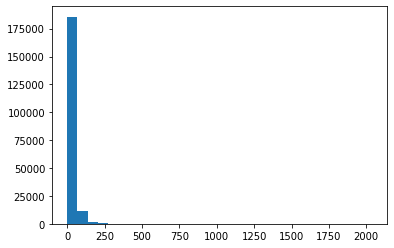

In [16]:
# Look at the token length of our descriptions

from matplotlib import pyplot as plt
plt.hist(reviews_df[0].apply(len), bins=30)

We see that the vast majority of these reviews are less than 300 words. They go up to over 2,000 words. We may have to experiment with how many tokens we allow into our input.

In [17]:
cats_df[0]

0         0
1         0
2         0
3         0
4         0
         ..
199995    0
199996    0
199997    0
199998    0
199999    4
Name: 0, Length: 200000, dtype: int64

Create dictionary for going back and forth between codes and category names. This comes from the example baseline code we were given.

In [18]:
category_dict = {
  0: "Women",
  1: "Men",
  2: "Girls",
  3: "Boys",
  4: "Baby"
}
category_dict

{0: 'Women', 1: 'Men', 2: 'Girls', 3: 'Boys', 4: 'Baby'}

### Modeling: Partition into train and validation
Our test data is separate and will be submitted to Kaggle. Here will will divide data into training and validation.

In [0]:
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.contrib import text
import numpy
import random
npx.set_np()

In [20]:
# Partition into training and test
train_pct = .9
# Test set will be remainder of examples

num_examples = len(cats_df[0])
rownums = list(range(num_examples))

random.seed(1729) # Set seed so test data doesn't leak across multiple sessions.
random.shuffle(rownums)
# Since this ordering is consistant, we will have the same 10% of test rows held out that we held out during training.


train_examples = int(num_examples * train_pct)

trainsetnums = rownums[:train_examples]
validsetnums = rownums[train_examples: ]

print("Train/Validate count: ", len(trainsetnums), len(validsetnums))

Train/Validate count:  180000 20000


In [0]:
Examples_train = list(reviews_df[0][trainsetnums])
Examples_validation = list(reviews_df[0][validsetnums])

train_labels = list(cats_df[0][trainsetnums])
validation_labels = list(cats_df[0][validsetnums])

In [22]:
y_train = np.array(cats_df[0][trainsetnums], dtype = np.float32).reshape(-1, 1)
y_validation = np.array(cats_df[0][validsetnums], dtype = np.float32).reshape(-1, 1)


print(y_train.shape, len(Examples_train))
print(y_validation.shape, len(Examples_validation))

(180000, 1) 180000
(20000, 1) 20000


In [0]:
train_tokens = Examples_train
validation_tokens = Examples_validation

Let's look at some random examples from the training data to see if our headlines and categories make sense.

In [24]:
example_num = random.randint(0,len(trainsetnums))
print(train_tokens[example_num])
print(category_dict.get(int(y_train[example_num])))

['pretty', 'purchased', 'works', 'really', 'well', 'inexpensive', 'gift', 'woman']
Women


### Word Embeddings

In [0]:
# import d2l
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>']) 

In [26]:
print(vocab.token_freqs[:20]) # Check the most frequent words. Stop words and special characters have been removed.

[('like', 59391), ('size', 57663), ('wear', 54584), ('fit', 54035), ('great', 49966), ('would', 40325), ('comfortable', 40018), ('love', 39835), ('good', 38786), ('well', 37032), ('one', 34230), ('shoes', 32858), ('nice', 30322), ('really', 30102), ('look', 28610), ('little', 27529), ('bought', 27371), ('im', 26160), ('get', 24624), ('dont', 23287)]


In [27]:
# Load pre-trained GloVe word embedding. This is available as a resource in mxnet. 
# We'll follow d2l's lead and use the 100d version
glove_embedding = text.embedding.create(
    'glove', pretrained_file_name='glove.6B.100d.txt')

# Check the dimentions of our embeddings (should be vocab size x dimensionality of embedding we chose)
embeds = glove_embedding.get_vecs_by_tokens(vocab.idx_to_token)
embeds.shape

(21175, 100)

### Data Iterator

In [28]:
num_steps = 50  # Sequence length. 
train_features = np.array([d2l.truncate_pad(  
    vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
print(train_features.shape)

validation_features = np.array([d2l.truncate_pad(  
    vocab[line], num_steps, vocab['<pad>']) for line in validation_tokens])
print(validation_features.shape)

(180000, 50)
(20000, 50)


In [0]:
X_train = np.array(train_features, dtype = np.float32)
X_validation = np.array(validation_features, dtype = np.float32)

In [30]:
batch_size = 128
train_iter = d2l.load_array((train_features, train_labels), batch_size)  
validation_iter = d2l.load_array((validation_features, validation_labels), batch_size, is_train = False)   



for X, y in train_iter:
    print('X', X.shape, 'y', y.shape)
    break
'# batches:', len(train_iter)

X (128, 50) y (128,)


('# batches:', 1407)

### Training Loop

In [0]:
def train(net, train_features, train_labels, test_features, test_labels, 
          num_epochs, lr, batch_size, ctx=d2l.try_gpu()):
  loss = gluon.loss.SoftmaxCrossEntropyLoss()
  train_ls, train_acc, test_acc = [], [], []
  train_iter = d2l.load_array((train_features, train_labels), batch_size)
  test_iter = d2l.load_array((test_features, test_labels), batch_size, is_train = False)
  trainer = gluon.Trainer(net.collect_params(),
                              'adam', {'learning_rate': lr})
  
  for epoch in range(num_epochs):
    train_acc_minibatch = []
    train_ls_minibatch = []
    test_acc_minibatch = []
    for i, (X, y) in enumerate(train_iter):
      X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
      with autograd.record():
        y_hat = net(X)
        l = loss(y_hat, y)
      l.backward()
      # print("Minibatch Completed")
      if(len(y) == batch_size): # Only calculate on full minibatches
        train_accuracy = (net(X).argmax(axis = 1).reshape(-1, 1) == 
                          y).sum()/len(y)
        train_loss = loss(net(X), y).mean()
        train_acc_minibatch.append(train_accuracy)
        train_ls_minibatch.append(train_loss)
      # print(train_accuracy)
      trainer.step(batch_size)

    # Validation set is too large to evaluate all at once.
    # Loop to evaluate test accuracy in minibatches.
    for i, (Xtest, ytest) in enumerate(test_iter):
      Xtest, ytest = Xtest.as_in_ctx(ctx), ytest.as_in_ctx(ctx)
      if(len(ytest) == batch_size): # Only calculate on full minibatches
        test_accuracy = (net(Xtest).argmax(axis = 1).reshape(-1, 1) == 
                          ytest).sum()/len(ytest)
        test_acc_minibatch.append(test_accuracy)


    train_acc.append(np.array(train_acc_minibatch).mean())
    test_acc.append(np.array(test_acc_minibatch).mean())
    train_ls.append(np.array(train_ls_minibatch).mean())
    print("Epoch = %d: Train acc: %f, Test acc: = %f" % (epoch, train_acc[-1], test_acc[-1]))
  return train_ls, train_acc, test_acc

### Bi-LSTM with Avg Pooling Layer

Using this as model that was most successful during previous text classification project. Will go back and search other models.

In [0]:
class AvgPoolBiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(AvgPoolBiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set Bidirectional to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                layout = 'NTC',
                                bidirectional=True, input_size=embed_size,
                                dropout = 0.2)
        self.avgpool = nn.AvgPool1D(pool_size = 5, strides = 5, layout = 'NCW')
        self.decoder = nn.Dense(5)

    def forward(self, inputs):
        # The shape of inputs is (batch size, number of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (number of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different timestep (outputs). The shape of outputs is
        # (number of words, batch size, 2 * number of hidden units).
        outputs = self.encoder(embeddings)
        hidden_1 = self.avgpool(outputs)
        # Concatenate the hidden states of the initial timestep and final
        # timestep to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * number of hidden units)
        outs = self.decoder(hidden_1)
        return outs

In [0]:
embed_size, num_hiddens, num_layers, ctx = 100, 200, 2, d2l.try_all_gpus()
net = AvgPoolBiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=ctx)

net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

Epoch = 0: Train acc: 0.799414, Test acc: = 0.823768
Epoch = 1: Train acc: 0.831070, Test acc: = 0.831981
Epoch = 2: Train acc: 0.840938, Test acc: = 0.829077
Epoch = 3: Train acc: 0.844461, Test acc: = 0.829577
Epoch = 4: Train acc: 0.849684, Test acc: = 0.830278
Training time 238.00260 sec
Training loss: 0.371424
Train accuracy: 0.849684
Test accuracy: 0.830278


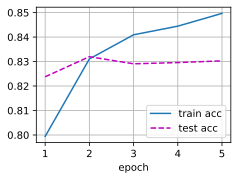

In [37]:
lr, num_epochs, batch_size = 0.01, 5, 128

timer = d2l.Timer()
train_ls, train_acc, test_acc = train(net, X_train, y_train, X_validation, y_validation, num_epochs, lr, batch_size)
print('Training time %.5f sec' % timer.stop())

d2l.plot(np.arange(1, num_epochs + 1), [train_acc, test_acc], xlabel='epoch',
              legend=['train acc', 'test acc'])
print("Training loss: %f" % train_ls[-1])
print("Train accuracy: %f" % train_acc[-1])
print("Test accuracy: %f" % test_acc[-1])

In [39]:
# Look at random validation examples, their actual categories, and their predicted categories

example_num = random.randint(0,len(validation_labels))
pred_example = np.array(validation_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))

print(validation_tokens[example_num])
print("Actual: ", category_dict.get(int(y_validation[example_num])))
print("Predicted: ", pred_cat)

['image', 'good', 'reference', 'case', 'turned', 'little', 'bigger', 'expected', 'although', 'quite', 'practical']
Actual:  Women
Predicted:  Women


In [40]:
pred_array = net(pred_example).reshape(1, -1)[0]
pred_array

array([ 1.2105318,  0.5755769, -2.8257065, -2.9190865, -2.9381242], ctx=gpu(0))

In [0]:
def Softmax(x):
  softmax = np.exp(x)/sum(np.exp(x))
  return softmax


In [42]:
Softmax(pred_array)

array([0.6331126 , 0.33552396, 0.01118317, 0.01018616, 0.00999407], ctx=gpu(0))

In [45]:
# Now show these predictions with their softmax vectors

example_num = random.randint(0,len(validation_labels))
pred_example = np.array(validation_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))
pred_array = net(pred_example).reshape(1, -1)[0][0:5]

print(validation_tokens[example_num])
print("Actual: ", category_dict.get(int(y_validation[example_num])))
print("Predicted: ", pred_cat)
print(Softmax(pred_array))


['musthave', 'every', 'day', 'home', 'yard', 'coffee', 'shop', 'walking', 'dog', 'comfy', 'fabric']
Actual:  Women
Predicted:  Women
[0.87555975 0.11245903 0.00733143 0.00202315 0.00262676] @gpu(0)


### Import test examples and make predictions

In [0]:
# Import Test Reviews and Categories

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)
    
test_reviews = []
for l in readGz("/content/drive/My Drive/test_Category.json.gz"):
    test_reviews.append(l['reviewText'])
    
test_ids = []
for l in readGz("/content/drive/My Drive/test_Category.json.gz"):
    test_ids.append(l['reviewerID'] + '-' + l['reviewHash'])

In [0]:
# Convert to pandas
test_reviews_df = pd.DataFrame(test_reviews)

In [0]:
# Convert to string
test_reviews_df[0] = test_reviews_df[0].astype("string")

# Remove special characters
test_reviews_df[0] = test_reviews_df[0].str.replace(r'[^\w\s]+','') 

# Convert to lower, tokenize, and remove stop words
test_reviews_df[0] = test_reviews_df[0].str.lower().str.split()
test_reviews_df[0] = test_reviews_df[0].apply(lambda x: [item for item in x if item not in stop])

In [49]:
test_reviews_df.head()

,0
0,"[love, blouse, fact, right, nowall, friends, l..."
1,"[cute, product, loved, fit, fast, shipping, wo..."
2,"[wanted, formal, watch, big, face, definitely,..."
3,"[daughter, used, dress, first, communion, fit,..."
4,"[nice, shirt, good, quality, pockets, kind, he..."


In [0]:
test_tokens = list(test_reviews_df[0])

In [51]:
test_features = np.array([d2l.truncate_pad(  
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
print(test_features.shape)

(14000, 50)


In [52]:
# Explore random predictions 
example_num = random.randint(0,len(test_features))
pred_example = np.array(test_features[example_num].reshape(1, -1), ctx=d2l.try_gpu())
pred_cat = category_dict.get(int(np.argmax(net(pred_example))))
pred_array = net(pred_example).reshape(1, -1)[0]

print(test_tokens[example_num])
print("Predicted: ", pred_cat)
print(Softmax(pred_array))

['really', 'like', 'scarf', 'color', 'pretty', 'tend', 'wear', 'lot', 'neutral', 'colors', 'scarves', 'great', 'way', 'add', 'little', 'color', 'got', 'great', 'price', 'think', 'worth', 'purchase', 'pretty', 'fall']
Predicted:  Women
[9.9016345e-01 8.4920879e-03 1.2713855e-03 4.4509703e-05 2.8494334e-05] @gpu(0)


In [0]:
# Store predictions in a list.
# There's not enough memory to run them all back through the network at once.
# We could use minibatches, but a loop will be fast enough.
predictions = []
predict_arrays = []
for i in range(len(test_features)):
  pred_example = np.array(test_features[i].reshape(1, -1), ctx=d2l.try_gpu())
  predictions.append(int(np.argmax(net(pred_example))))
  predict_arrays.append(Softmax(net(pred_example).reshape(1, -1)[0]))

In [54]:
predictions[:10]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0]

In [55]:
float(list(predict_arrays[:10][0])[0])

0.9805567860603333

In [0]:
# Create Export file
prediction_table = pd.DataFrame(test_ids, columns = ['reviewerID-reviewHash'])
prediction_table['category'] = predictions
prediction_table['probabilities'] = predict_arrays

In [57]:
prediction_table.head()

,reviewerID-reviewHash,category,probabilities
0,U281659737-R934811302,0,"[0.9805568, 0.0034704322, 0.015634341, 5.37766..."
1,U670561057-R657711680,0,"[0.98889446, 0.004986752, 0.0037448325, 0.0003..."
2,U433746872-R750304163,1,"[0.43378943, 0.5621194, 0.0024249884, 0.001423..."
3,U327816997-R865011815,0,"[0.8994861, 0.0024409154, 0.096926175, 0.00073..."
4,U323131234-R222729968,1,"[0.09200443, 0.9015657, 0.0008069256, 0.005316..."


In [0]:
# Export predictions
prediction_table.to_csv('/content/drive/My Drive/prediction-categories-lstm-probs-fixed.csv')